<a href="https://colab.research.google.com/github/1-gagandeep/1-gagandeep/blob/main/flowers_recognisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

In [5]:
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [6]:
# supervised_keys=('image', 'label')
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [7]:
for i, example in enumerate(dataset['train']):
  image,label = example
  save_dir = 'tf_flowers/train/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)

  filepath = save_dir + "/" + "{}_{}.jpg".format(class_names[label], i)
  tf.keras.preprocessing.image.save_img(filepath, image.numpy())
  # print(filepath)
  # break

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [9]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2,
                             rotation_range=10, width_shift_range = 0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_generator = datagen.flow_from_directory('tf_flowers/train', target_size=(224,224), batch_size=4,
                                              class_mode="categorical", subset='training')

validation_generator = datagen.flow_from_directory('tf_flowers/train', target_size=(224,224), batch_size=4,
                                              class_mode="categorical", subset='validation')


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [10]:
# create base model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

In [12]:
history=model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
735/735 [==============================] - 87s 107ms/step - loss: 1.3190 - accuracy: 0.4433 - val_loss: 1.1318 - val_accuracy: 0.5239
Epoch 2/5
735/735 [==============================] - 76s 103ms/step - loss: 1.0942 - accuracy: 0.5692 - val_loss: 1.0295 - val_accuracy: 0.6265
Epoch 3/5
735/735 [==============================] - 79s 107ms/step - loss: 0.9980 - accuracy: 0.6247 - val_loss: 0.9201 - val_accuracy: 0.6648
Epoch 4/5
735/735 [==============================] - 77s 105ms/step - loss: 0.9080 - accuracy: 0.6604 - val_loss: 0.8938 - val_accuracy: 0.6498
Epoch 5/5
735/735 [==============================] - 77s 105ms/step - loss: 0.8477 - accuracy: 0.6805 - val_loss: 0.8254 - val_accuracy: 0.6785


In [13]:
# VGG 16 Model
from tensorflow.keras.applications import VGG16
model_vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
for layer in model_vgg16.layers:
  layer.trainable=False

model_vgg16.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
735/735 [==============================] - 59s 76ms/step - loss: 1.6241 - accuracy: 0.5315 - val_loss: 0.9053 - val_accuracy: 0.6635
Epoch 2/5
735/735 [==============================] - 52s 71ms/step - loss: 0.9458 - accuracy: 0.6370 - val_loss: 0.6644 - val_accuracy: 0.7442
Epoch 3/5
735/735 [==============================] - 53s 71ms/step - loss: 0.8682 - accuracy: 0.6676 - val_loss: 0.6323 - val_accuracy: 0.7729
Epoch 4/5
735/735 [==============================] - 53s 73ms/step - loss: 0.8384 - accuracy: 0.6836 - val_loss: 0.6015 - val_accuracy: 0.7743
Epoch 5/5
735/735 [==============================] - 53s 72ms/step - loss: 0.7836 - accuracy: 0.6982 - val_loss: 0.6133 - val_accuracy: 0.7688


In [17]:
model.save('flowers_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
flowers = tf.keras.models.load_model('flowers_classifier.h5')

In [20]:
flowers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


1/1 [==============================] - 0s 19ms/step


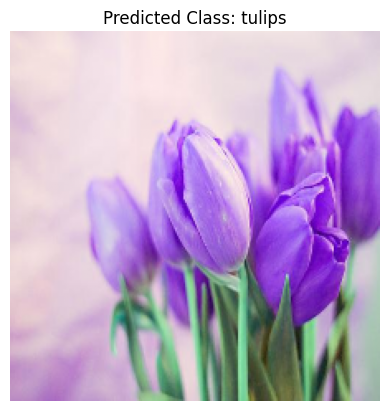

In [25]:
import cv2


# Load the image
img = cv2.imread('/content/tf_flowers/train/tulips/tulips_1033.jpg')
img = cv2.resize(img, (224, 224))
img = np.reshape(img, (224, 224, 3))  # Correct reshaping
img = img / 255

# Predict the class probabilities
preds = flowers.predict(np.expand_dims(img, axis=0))  # Expand dimensions to match the model input shape

# Get the predicted class label
max_idx = np.argmax(preds)
class_indices = {v: k for k, v in train_generator.class_indices.items()}
predicted_class = class_indices[max_idx]

# Display the image and predicted class
plt.imshow(img)
plt.title("Predicted Class: " + predicted_class)
plt.axis('off')
plt.show()